In [1]:
import pandas as pd
from pprint import pprint
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import pyLDAvis
import pyLDAvis.gensim
stop=stopwords.words('english')
import spacy
import numpy as np
import re
from matplotlib import pyplot as plt
nlp=spacy.load('en_core_web_sm')
from gensim import corpora


/Users/mstudio/miniconda3/envs/py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load and preprocess the data

In [2]:
data=pd.read_excel('/Volumes/T7/UIUC/Summer_2023/IMLS/STEM programming coding - Goals Activities Outcomes - SHARE.xlsx')#, encoding='latin-1')

In [3]:
data.columns

Index(['New number', 'Project code', 'Project goals',
       'Project activities/outcomes',
       'Grant start year (when was this grant awarded)'],
      dtype='object')

In [4]:
data=data.fillna('') # fill empty cells with empty string
data['goal']=data['Project goals']+data['Project activities/outcomes']
data['goal']=data['goal'].str.lower()

In [5]:
def lemmatization(dataframe):
    dataframe['goal_lower'] = dataframe['goal'].astype(str).str.lower()
    dataframe['stopword'] = dataframe['goal_lower'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
    dataframe['punct'] = dataframe['stopword'].str.replace('[^\w\s]', '')
    dataframe['lemma'] = dataframe['punct'].apply(lambda row: ' '.join([w.lemma_ for w in nlp(row)]))
    dataframe['lemma_length'] = dataframe['lemma'].apply(lambda x: ' '.join([s for s in x.split() if s is not None and len(s) >= 3 and not re.match(r'^\d+$', s)]))
    dataframe['lemma_stop'] = dataframe['lemma_length'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
    dataframe['final'] = dataframe['lemma_stop'].apply(lambda row: ' '.join([w.lemma_ for w in nlp(row)]))
    dataframe['token'] = dataframe['final'].apply(word_tokenize)
    return dataframe

<>:4: DeprecationWarning: invalid escape sequence '\w'
<>:4: DeprecationWarning: invalid escape sequence '\w'
/var/folders/3_/r8z51q092v566bd_r0g_zj640000gn/T/ipykernel_3116/4137522434.py:4: DeprecationWarning: invalid escape sequence '\w'
  dataframe['punct'] = dataframe['stopword'].str.replace('[^\w\s]', '')


In [6]:
data=lemmatization(data)

NMF

In [7]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(data['final'])


In [8]:
num_topics = 6  # Replace with the desired number of topics
nmf = NMF(n_components=num_topics, random_state=42)
nmf.fit(tfidf_matrix)

from sklearn.decomposition import NMF

# Assuming you have already created and fit your NMF model, and you have a vectorizer

num_top_words = 10  # Replace with the desired number of top words

# Get the feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Iterate over topics
for topic_idx, topic in enumerate(nmf.components_):
    print(f"Topic #{topic_idx + 1}:")
    
    # Sort the words by their weights in the current topic
    # topic_words_indices= topic.argsort()[0:10]
    top_word_indices = topic.argsort()[:-num_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_word_indices]
    top_word_weights = [topic[i] for i in top_word_indices]
    
    # Print both the words and their weights
    for word, weight in zip(top_words, top_word_weights):
        print(f"{word}: {weight:.2f}")
    
    print()


Topic #1:
library: 1.08
public: 0.46
county: 0.37
skill: 0.27
teen: 0.25
community: 0.23
stem: 0.23
partnership: 0.23
provide: 0.22
development: 0.22

Topic #2:
student: 0.62
school: 0.40
stem: 0.27
center: 0.25
program: 0.24
activity: 0.22
provide: 0.19
learn: 0.18
pandemic: 0.15
science: 0.15

Topic #3:
information: 0.54
university: 0.35
datum: 0.32
librarian: 0.24
school: 0.23
project: 0.23
science: 0.21
research: 0.19
learn: 0.16
study: 0.16

Topic #4:
citizen: 0.73
scientist: 0.32
science: 0.31
arizona: 0.23
library: 0.17
garden: 0.16
project: 0.16
state: 0.16
scistarter: 0.15
scale: 0.13

Topic #5:
tribal: 0.52
book: 0.39
tribe: 0.35
native: 0.24
library: 0.23
shawnee: 0.22
nation: 0.21
collection: 0.19
youth: 0.18
cultural: 0.18

Topic #6:
museum: 0.53
community: 0.39
program: 0.33
digital: 0.32
science: 0.20
content: 0.20
stem: 0.19
family: 0.18
child: 0.18
project: 0.17



/Users/mstudio/miniconda3/envs/py3.10/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [9]:
dominant_topics = np.argmax(nmf.transform(tfidf_matrix), axis=1)
data['dominant_topic'] = dominant_topics
data['dominant_topic']=data['dominant_topic']+1

In [10]:
topic_distribution=nmf.transform(tfidf_matrix)
document_topic_dict = {}

for doc_idx in range(len(data)):
    topic_dict = {}
    for topic_idx in range(num_topics):
        topic_dict[topic_idx] = topic_distribution[doc_idx, topic_idx]
    document_topic_dict[doc_idx] = topic_dict
data['topic_dist']=document_topic_dict

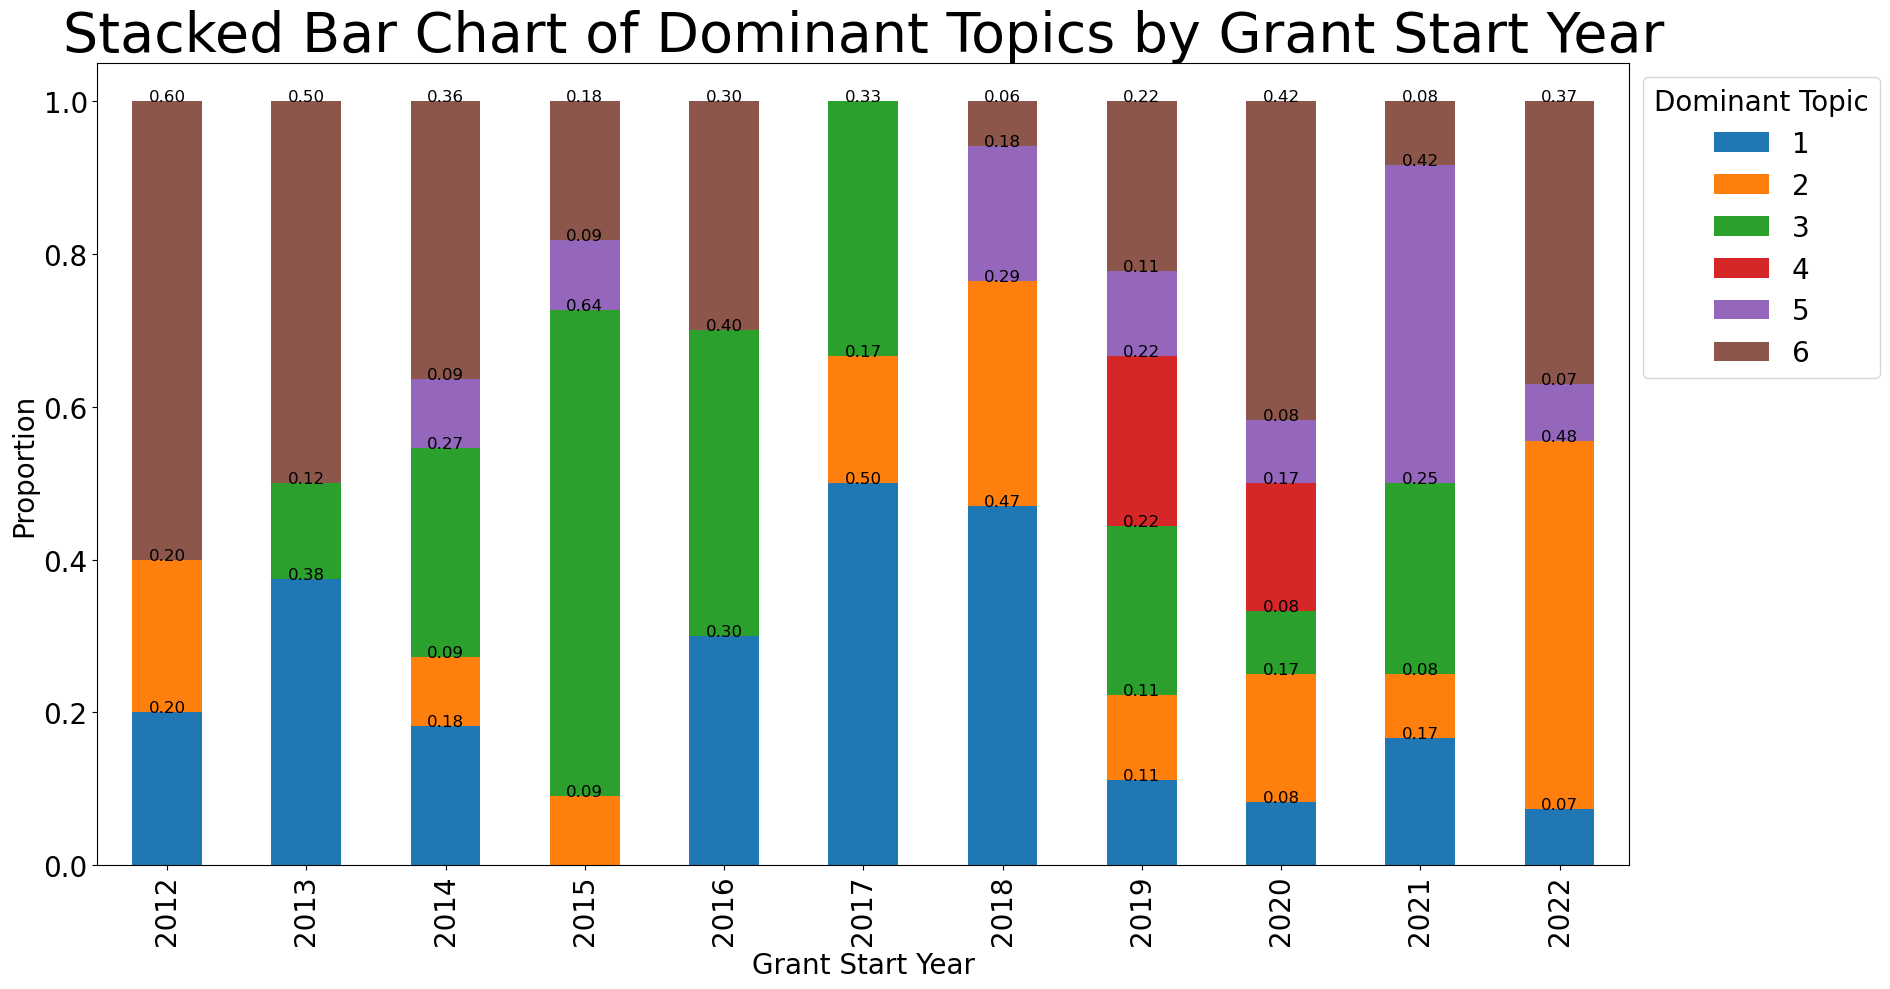

In [11]:
grouped_data = data.groupby(['Grant start year (when was this grant awarded)', 'dominant_topic']).size()
reshaped_data = grouped_data.unstack(level='dominant_topic')
normalized_data = reshaped_data.div(reshaped_data.sum(axis=1), axis=0)

ax = normalized_data.plot(kind='bar', stacked=True, figsize=(20, 10), fontsize=20)

plt.xlabel('Grant Start Year', fontsize=20)
plt.ylabel('Proportion', fontsize=20)

legend = ax.legend(title='Dominant Topic', bbox_to_anchor=(1, 1), loc='upper left', fontsize=20, title_fontsize=20)

plt.title('Stacked Bar Chart of Dominant Topics by Grant Start Year', fontsize=40)
plt.tight_layout(rect=[0, 0, 0.95, 1])


for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height == 0:
        continue
    else:
        ax.annotate(f'{height:.2f}', (x + width / 2, y + height), ha='center', fontsize=12)

plt.show()

In [12]:
data.groupby(['dominant_topic']).size()

dominant_topic
1    26
2    26
3    23
4     4
5    14
6    35
dtype: int64

Text(0.5, 1.0, 'Bar Chart of Dominant Topics')

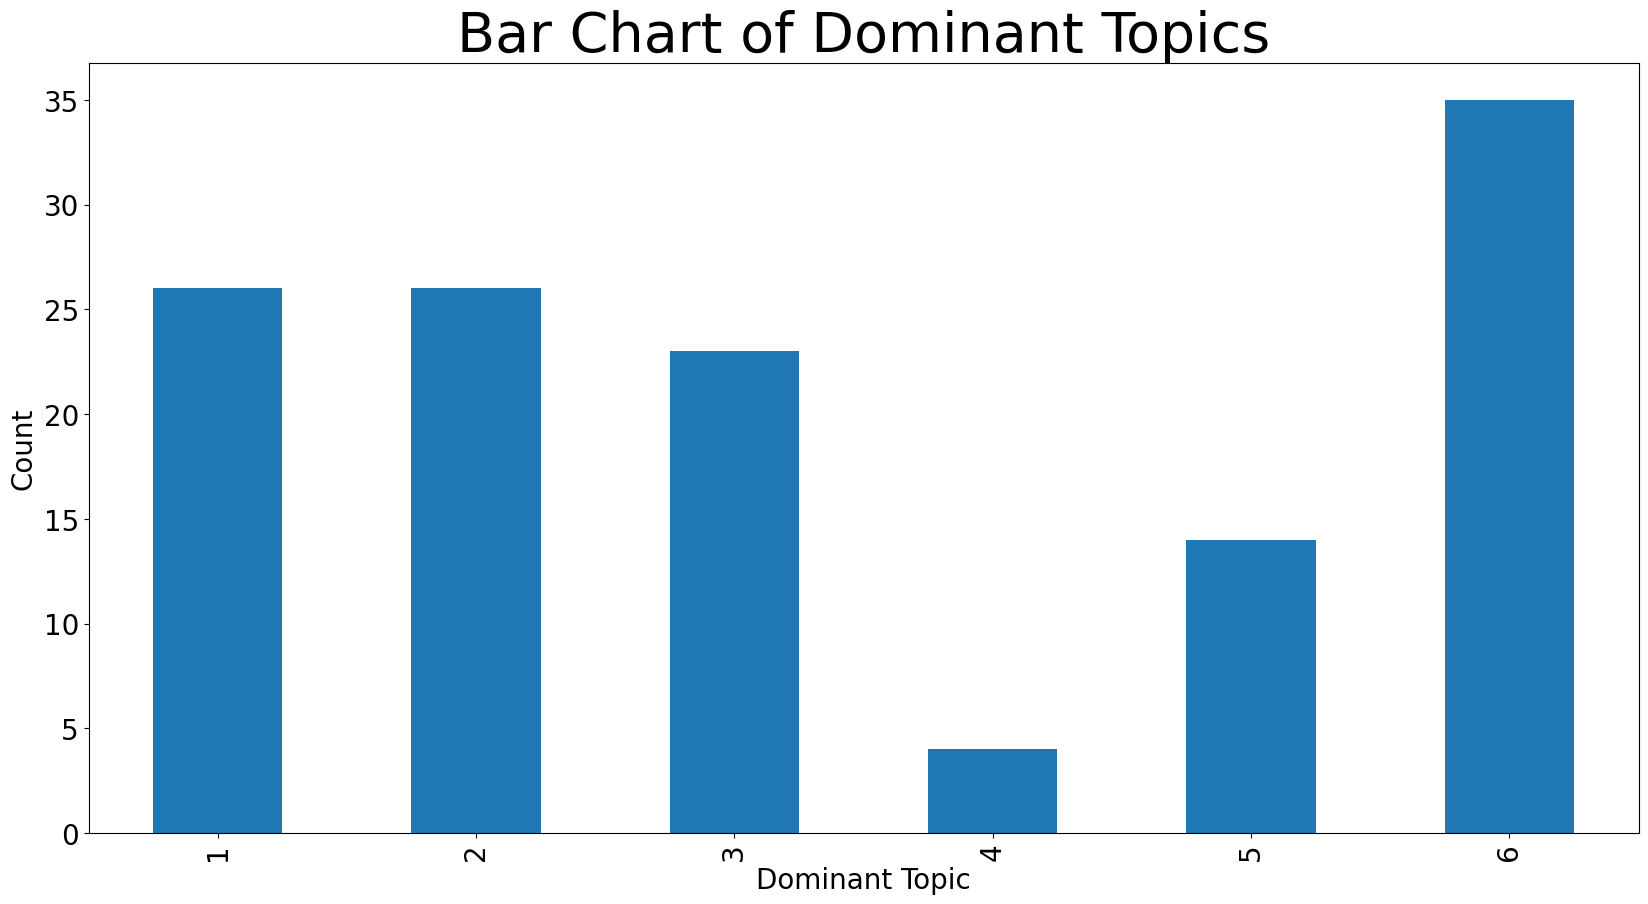

In [39]:
plt.figure(figsize=(20, 10))
data.groupby(['dominant_topic']).size().plot(kind='bar', figsize=(20, 10), fontsize=20)#, ylabel='Count', xlabel='Dominant Topic', title='Bar Chart of Dominant Topics')
plt.xlabel('Dominant Topic', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title('Bar Chart of Dominant Topics', fontsize=40)

/var/folders/3_/r8z51q092v566bd_r0g_zj640000gn/T/ipykernel_3116/72363850.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.1f}%'.format(x) for x in plt.gca().get_yticks()])  # Format y-axis as percentages


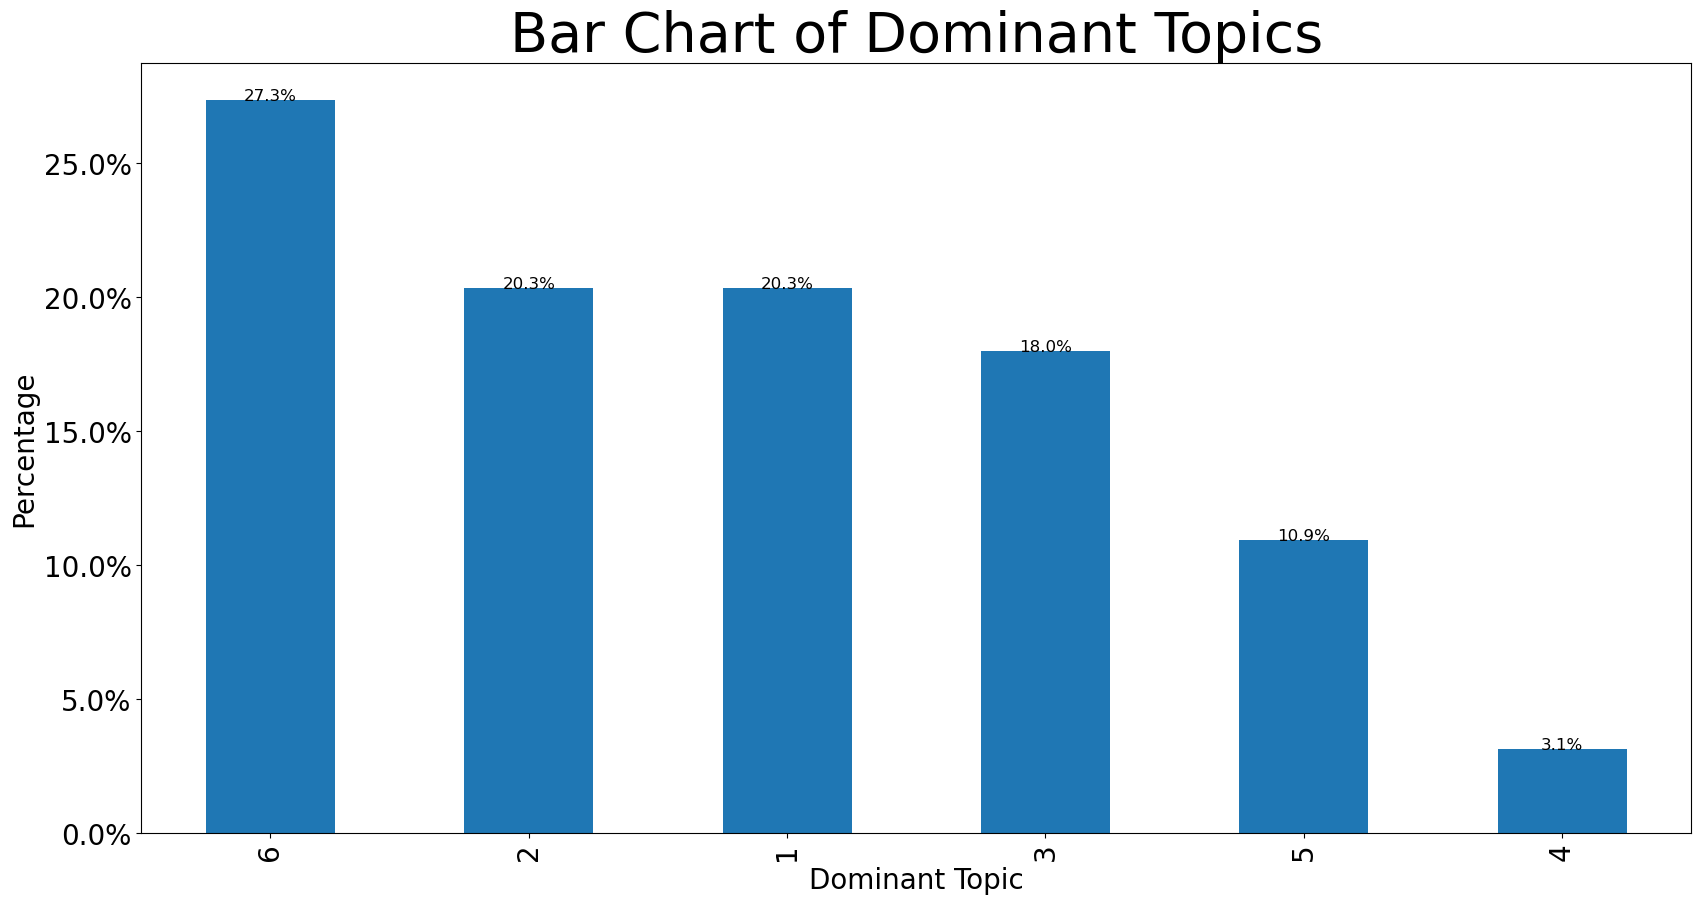

In [18]:
import matplotlib.pyplot as plt

# Calculate the percentage for each dominant topic
topic_counts = data['dominant_topic'].value_counts()
total_count = len(data)
topic_percentages = (topic_counts / total_count) * 100

# Create the bar chart with percentages and annotations
plt.figure(figsize=(20, 10))
ax = topic_percentages.plot(kind='bar', figsize=(20, 10), fontsize=20)
plt.xlabel('Dominant Topic', fontsize=20)
plt.ylabel('Percentage', fontsize=20)
plt.title('Bar Chart of Dominant Topics', fontsize=40)

# Annotate each bar with its percentage value
for i, percentage in enumerate(topic_percentages):
    ax.text(i, percentage, f'{percentage:.1f}%', ha='center', fontsize=12)

plt.gca().set_yticklabels(['{:.1f}%'.format(x) for x in plt.gca().get_yticks()])  # Format y-axis as percentages
plt.show()


get rid of "stem" word 

In [12]:
stop.append('library')
stop.append('stem')
data=lemmatization(data)

In [13]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(data['final'])

In [14]:
num_topics = 6  # Replace with the desired number of topics
nmf = NMF(n_components=num_topics, random_state=42)
nmf.fit(tfidf_matrix)

from sklearn.decomposition import NMF

# Assuming you have already created and fit your NMF model, and you have a vectorizer

num_top_words = 10  # Replace with the desired number of top words

# Get the feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Iterate over topics
for topic_idx, topic in enumerate(nmf.components_):
    print(f"Topic #{topic_idx + 1}:")
    
    # Sort the words by their weights in the current topic
    # topic_words_indices= topic.argsort()[0:10]
    top_word_indices = topic.argsort()[:-num_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_word_indices]
    top_word_weights = [topic[i] for i in top_word_indices]
    
    # Print both the words and their weights
    for word, weight in zip(top_words, top_word_weights):
        print(f"{word}: {weight:.2f}")
    
    print()

Topic #1:
student: 0.90
school: 0.58
center: 0.35
program: 0.31
activity: 0.29
provide: 0.29
learn: 0.26
opportunity: 0.20
pandemic: 0.19
19: 0.19

Topic #2:
information: 0.50
university: 0.35
datum: 0.32
librarian: 0.31
school: 0.25
professional: 0.24
project: 0.23
science: 0.22
learn: 0.21
model: 0.20

Topic #3:
tribal: 0.39
book: 0.32
tribe: 0.29
service: 0.25
native: 0.20
collection: 0.19
summer: 0.18
youth: 0.17
culture: 0.17
nation: 0.16

Topic #4:
museum: 0.57
community: 0.35
program: 0.29
family: 0.24
child: 0.24
science: 0.19
digital: 0.19
content: 0.18
member: 0.17
deliver: 0.16

Topic #5:
teen: 0.38
county: 0.29
digital: 0.28
public: 0.24
skill: 0.24
space: 0.23
community: 0.23
workforce: 0.21
medium: 0.20
program: 0.19

Topic #6:
citizen: 0.90
scientist: 0.39
science: 0.38
arizona: 0.28
project: 0.20
garden: 0.19
state: 0.19
scistarter: 0.18
scale: 0.16
engage: 0.15



In [15]:
dominant_topics = np.argmax(nmf.transform(tfidf_matrix), axis=1)
data['dominant_topic'] = dominant_topics

In [16]:
dominant_topics = np.argmax(nmf.transform(tfidf_matrix), axis=1)
data['dominant_topic'] = dominant_topics

topic_distribution=nmf.transform(tfidf_matrix)
document_topic_dict = {}

for doc_idx in range(len(data)):
    topic_dict = {}
    for topic_idx in range(num_topics):
        topic_dict[topic_idx] = topic_distribution[doc_idx, topic_idx]
    document_topic_dict[doc_idx] = topic_dict
data['topic_dist']=document_topic_dict

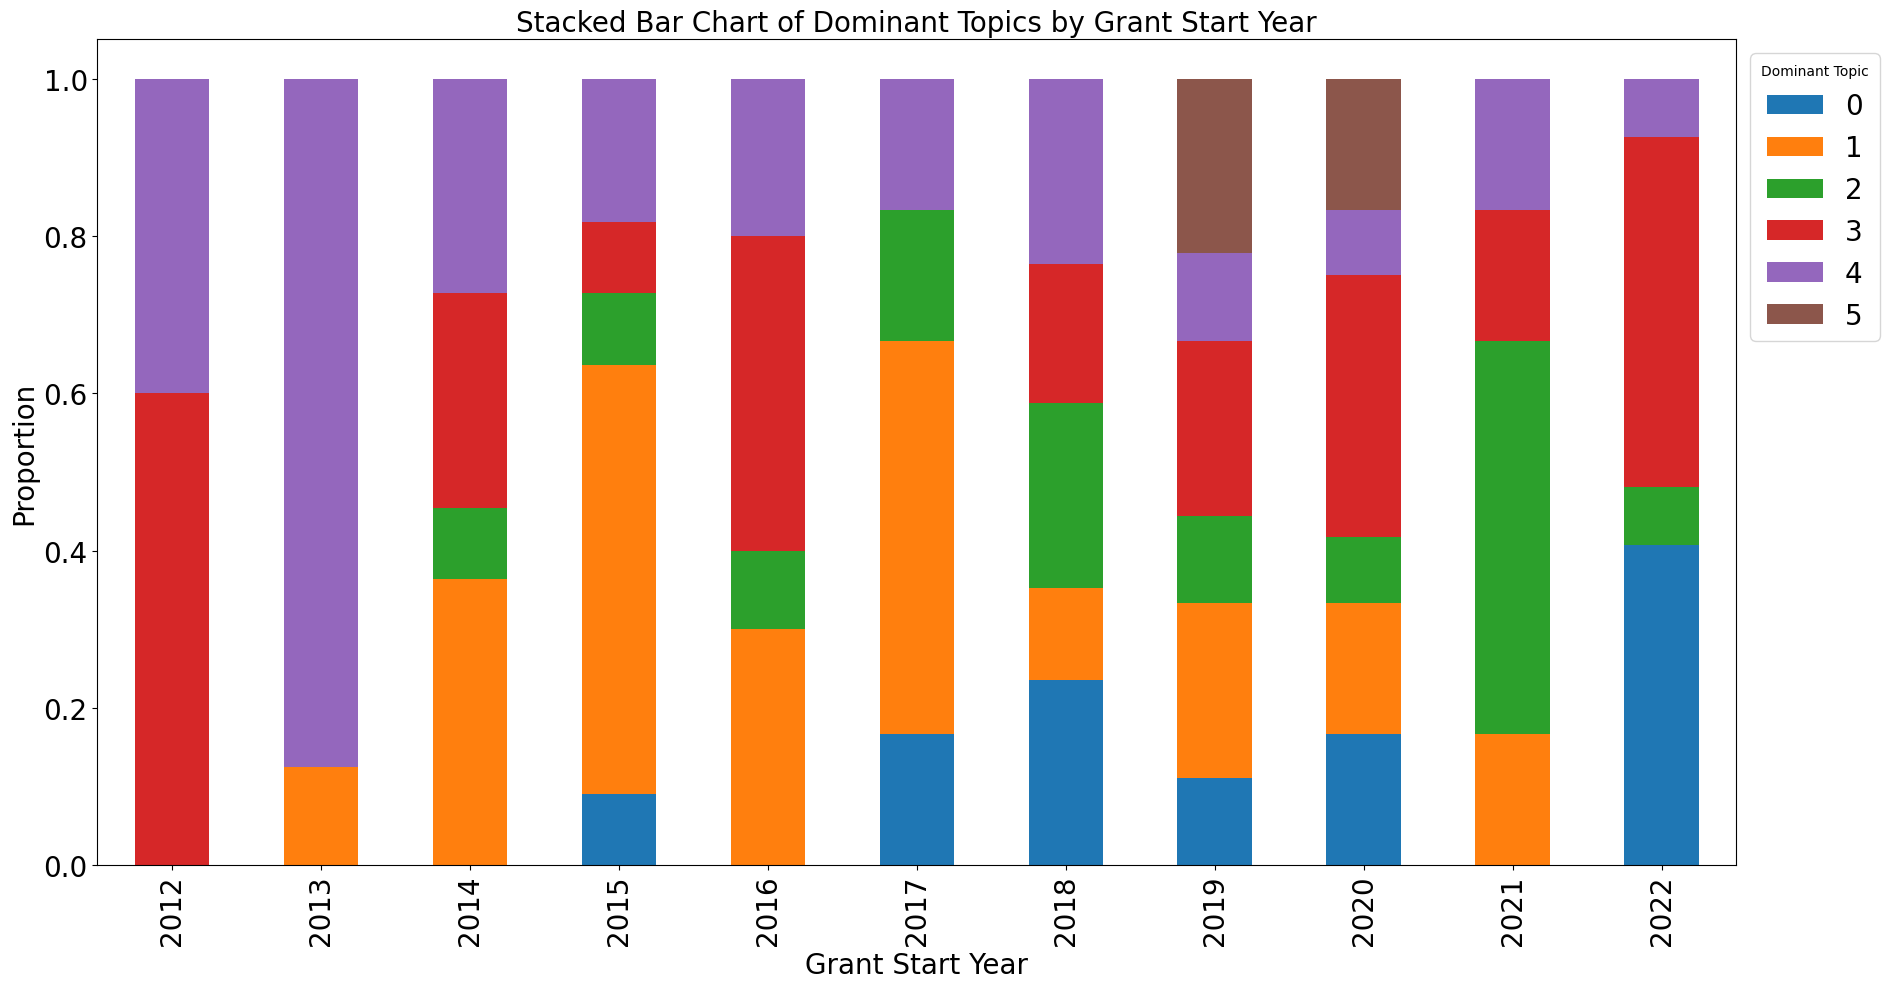

In [17]:
grouped_data = data.groupby(['Grant start year (when was this grant awarded)', 'dominant_topic']).size()
reshaped_data = grouped_data.unstack(level='dominant_topic')
normalized_data = reshaped_data.div(reshaped_data.sum(axis=1), axis=0)

ax = normalized_data.plot(kind='bar', stacked=True, figsize=(20, 10), fontsize=20)

plt.xlabel('Grant Start Year', fontsize=20)
plt.ylabel('Proportion', fontsize=20)

legend = ax.legend(title='Dominant Topic', bbox_to_anchor=(1, 1), loc='upper left', fontsize=20)

plt.title('Stacked Bar Chart of Dominant Topics by Grant Start Year', fontsize=20)
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

get rid of "stem" and "library" word

In [18]:
stop.append('library')
data=lemmatization(data)

In [19]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(data['final'])

In [20]:
num_topics = 6  # Replace with the desired number of topics
nmf = NMF(n_components=num_topics, random_state=42)
nmf.fit(tfidf_matrix)

from sklearn.decomposition import NMF

# Assuming you have already created and fit your NMF model, and you have a vectorizer

num_top_words = 10  # Replace with the desired number of top words

# Get the feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Iterate over topics
for topic_idx, topic in enumerate(nmf.components_):
    print(f"Topic #{topic_idx + 1}:")
    
    # Sort the words by their weights in the current topic
    # topic_words_indices= topic.argsort()[0:10]
    top_word_indices = topic.argsort()[:-num_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_word_indices]
    top_word_weights = [topic[i] for i in top_word_indices]
    
    # Print both the words and their weights
    for word, weight in zip(top_words, top_word_weights):
        print(f"{word}: {weight:.2f}")
    
    print()

Topic #1:
student: 0.90
school: 0.58
center: 0.35
program: 0.31
activity: 0.29
provide: 0.29
learn: 0.26
opportunity: 0.20
pandemic: 0.19
19: 0.19

Topic #2:
information: 0.50
university: 0.35
datum: 0.32
librarian: 0.31
school: 0.25
professional: 0.24
project: 0.23
science: 0.22
learn: 0.21
model: 0.20

Topic #3:
tribal: 0.39
book: 0.32
tribe: 0.29
service: 0.25
native: 0.20
collection: 0.19
summer: 0.18
youth: 0.17
culture: 0.17
nation: 0.16

Topic #4:
museum: 0.57
community: 0.35
program: 0.29
family: 0.24
child: 0.24
science: 0.19
digital: 0.19
content: 0.18
member: 0.17
deliver: 0.16

Topic #5:
teen: 0.38
county: 0.29
digital: 0.28
public: 0.24
skill: 0.24
space: 0.23
community: 0.23
workforce: 0.21
medium: 0.20
program: 0.19

Topic #6:
citizen: 0.90
scientist: 0.39
science: 0.38
arizona: 0.28
project: 0.20
garden: 0.19
state: 0.19
scistarter: 0.18
scale: 0.16
engage: 0.15



In [21]:
dominant_topics = np.argmax(nmf.transform(tfidf_matrix), axis=1)
data['dominant_topic'] = dominant_topics

In [22]:
dominant_topics = np.argmax(nmf.transform(tfidf_matrix), axis=1)
data['dominant_topic'] = dominant_topics

topic_distribution=nmf.transform(tfidf_matrix)
document_topic_dict = {}

for doc_idx in range(len(data)):
    topic_dict = {}
    for topic_idx in range(num_topics):
        topic_dict[topic_idx] = topic_distribution[doc_idx, topic_idx]
    document_topic_dict[doc_idx] = topic_dict
data['topic_dist']=document_topic_dict

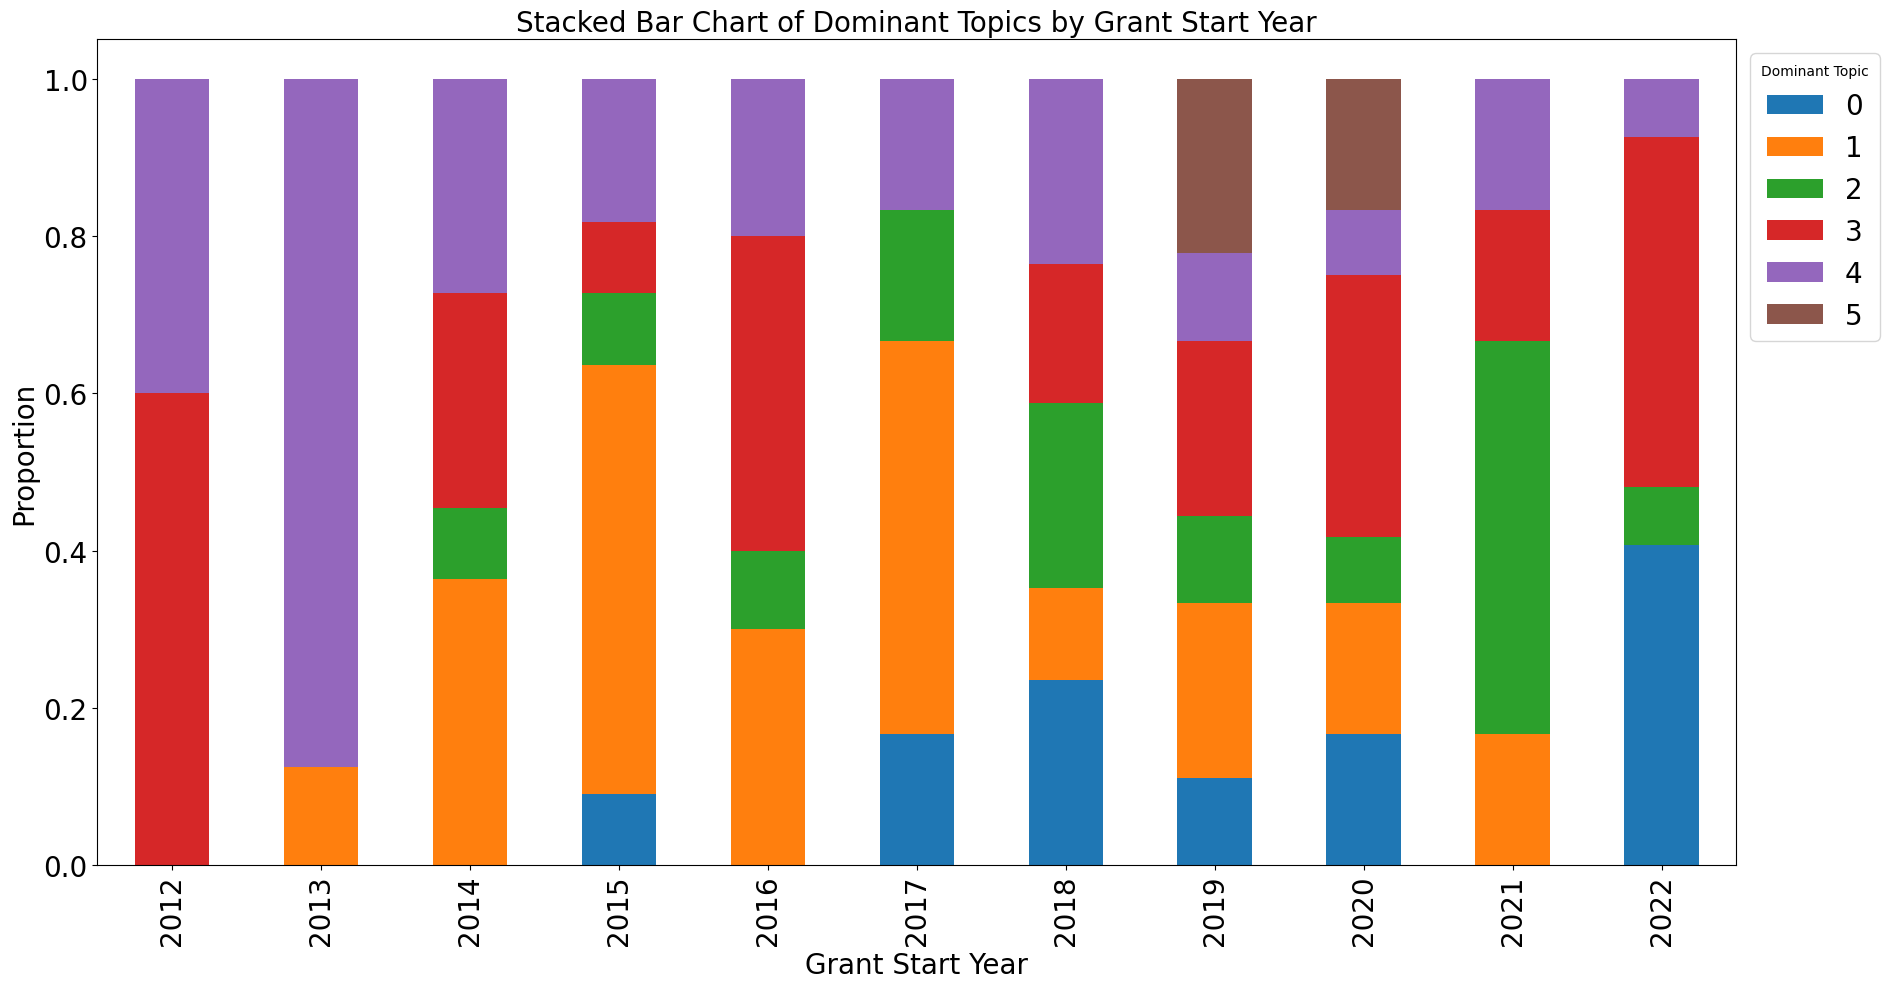

In [23]:
grouped_data = data.groupby(['Grant start year (when was this grant awarded)', 'dominant_topic']).size()
reshaped_data = grouped_data.unstack(level='dominant_topic')
normalized_data = reshaped_data.div(reshaped_data.sum(axis=1), axis=0)

ax = normalized_data.plot(kind='bar', stacked=True, figsize=(20, 10), fontsize=20)

plt.xlabel('Grant Start Year', fontsize=20)
plt.ylabel('Proportion', fontsize=20)

legend = ax.legend(title='Dominant Topic', bbox_to_anchor=(1, 1), loc='upper left', fontsize=20)

plt.title('Stacked Bar Chart of Dominant Topics by Grant Start Year', fontsize=20)
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()